<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Analyse-chopping" data-toc-modified-id="Analyse-chopping-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Analyse chopping</a></span><ul class="toc-item"><li><span><a href="#Optimal-chops-search-for-task" data-toc-modified-id="Optimal-chops-search-for-task-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Optimal chops search for task</a></span></li></ul></li></ul></div>

In [205]:
import sys
sys.path.append('..')
sys.path.append('./qaoa')

In [206]:
import pyrofiler as prof
from multiprocessing.dummy import Pool
import utils_qaoa as qaoa
import utils
import numpy as np
import qtree
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import memcached_qaoa_utils as cached_utils
sns.set_style('whitegrid')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analyse chopping


In [28]:
chop_pts = 3
def get_chop_idxs(graph, peo, cost, nghs):
    drop_idx = get_chop_dn_drop(nghs)
    min_idx = np.argmin(cost[0][:drop_idx])
    before_min = min_idx - (drop_idx-min_idx)
    on_plato = 2 * min_idx // 3
        
    return min_idx, drop_idx, drop_idx+5

def _cost_before_chop(idxs, cost):
    mems, floats = cost
    before_mem = [max(mems[:i]) for i in idxs]
    return before_mem

def get_chop_dn_drop(nghs):
    nghs = np.array(nghs)
    dn = nghs[1:] - nghs[:-1]
    neg_idx = [i for i, n in enumerate(dn) if n<0]
    pos_idx = [i for i, n in enumerate(dn) if n>0]
    drop_idx = neg_idx[0]
    pos_idx.reverse()
    before_drop = [i for i in pos_idx if i<drop_idx]
    return before_drop[0] - 1




In [218]:
peo, nghs= cached_utils.neigh_peo(23)
costs = cached_utils.graph_contraction_costs(23, peo)

________________________________________________________________________________
[Memory] Calling memcached_qaoa_utils.graph_contraction_costs...
graph_contraction_costs(23, [ 288,
  289,
  290,
  291,
  292,
  293,
  294,
  295,
  296,
  297,
  298,
  299,
  300,
  301,
  302,
  303,
  304,
  305,
  306,
  307,
  308,
  309,
  310,
  311,
  312,
  313,
  314,
  315,
  316,
  317,
  318,
  319,
  320,
  321,
  322,
  323,
  324,
  325,
  326,
  327,
  328,
  329,
  330,
  331,
  332,
  333,
  334,
  335,
  336,
  337,
  338,
  339,
  340,
  341,
  342,
  343,
  344,
  345,
  346,
  347,
  348,
  349,
  350,
  351,
  352,
  353,
  354,
  355,
  356,
  357,
  358,
  359,
  360,
  361,
  362,
  363,
  364,
  365,
  366,
  367,
  368,
  369,
  370,
  371,
  372,
  373,
  374,
  375,
  376,
  377,
  378,
  379,
  380,
  381,
  382,
  383,
  384,
  385,
  386,
  387,
...)
_________________________________________graph_contraction_costs - 87.1s, 1.5min


In [30]:
sizes = [12, 13]

tasks = [qaoa.get_test_expr_graph(s, 1) for s in sizes]
graphs =     [g for g, _ in tasks]
qbit_sizes = [N for _, N in tasks]

2020-03-12 16:57:26,054- INFO•	Generated graph with 688 nodes and 1498 edges
2020-03-12 16:57:26,299- INFO•	Generated graph with 742 nodes and 1617 edges


In [31]:
print('Qubit sizes', qbit_sizes)
pool = Pool(processes=1)

Qubit sizes [91, 98]


In [32]:
def n_peo(graph):
    return utils.get_locale_peo(graph, utils.n_neighbors)
peos_n = pool.map(n_peo, graphs)
peos, nghs = zip(*peos_n)

In [33]:
_get_cost = lambda x: qaoa.cost_graph_peo(*x)

with prof.timing('Get full costs naive'):
    costs = pool.map(_get_cost, zip(graphs, peos))

KeyboardInterrupt: 

In [ ]:
chopped_g = [
    contract_by_peo(g, peo[:_idx]) 
    for g, peo, cost, ng in tqdm( zip(graphs, peos, costs, nghs) )
    for _idx in get_chop_idxs(g, peo, cost, ng)
]

costs_before_chop = [
    mem
    for g, peo, cost, ng in tqdm( zip(graphs, peos, costs, nghs) )
    for mem in _cost_before_chop(get_chop_idxs(g, peo, cost, ng), cost)
]

In [ ]:
print('contracted graphs', [g.number_of_nodes() for g in chopped_g])

print('costs before chop', costs_before_chop)

In [ ]:
par_vars = [0,1,2,5, 7, 12]

parallelized_g = [
    g
    for graph in chopped_g
    for parvar in par_vars
    for  _, g in [qtree.graph_model.split_graph_by_metric(graph, n_var_parallel=parvar)]
]

In [ ]:
print('parallelised graphs', [g.number_of_nodes() for g in parallelized_g])

In [ ]:
def n_peo(graph):
    return utils.get_locale_peo(graph, utils.n_neighbors)
_pg_peos = tqdm(list(zip(parallelized_g, peos_par)))
with prof.timing('peos chopped'):
    peos_par_n = pool.map(n_peo, tqdm(parallelized_g))
peos_par, nghs_par = zip(*peos_par_n)


In [ ]:
def get_qbb_peo(graph):
    try:
        peo, tw = qtree.graph_model.get_peo(graph)
        fail = False
    except:
        print('QBB fail, nodes count:', graph.number_of_nodes())
        peo, nghs = utils.get_locale_peo(graph, utils.n_neighbors)
        fail = True
    return peo, fail

In [ ]:
peos_par = [ get_qbb_peo(g) for g in tqdm( parallelized_g ) ]
peos_par, fails_qbb = zip(*peos_par)

In [ ]:
tqdm._instances.clear()

In [ ]:
_pg_peos = tqdm(list(zip(parallelized_g, peos_par)))
with prof.timing('Costs chopped'):
    costs_all = pool.map(_get_cost, _pg_peos)


In [ ]:
experiment_name = 'small_chops_test'

In [ ]:
mems = [max(m) for m,_ in costs_all ]

In [ ]:
_data = np.array(mems).reshape(len(sizes), chop_pts, len(par_vars)) 

print(_data)
np.save(f'cached_data/{experiment_name}',_data)

In [134]:
def trid_plot(x, y, labels, dimspec=(0,1,2), figsize=(15,4)): 
    y = y.transpose(dimspec)
    plot_cnt = y.shape[0]
    line_cnt = y.shape[1]
    def _label_of(dim, idx):
        return labels[dim] + ' ' + str(x[dim][idx])
    
    fig, axs = plt.subplots(1, plot_cnt, sharey=True, figsize=figsize)
    try:
        iter(axs)
    except TypeError:
        axs = [axs]
    for i, ax in enumerate(axs):
        plt.sca(ax)
        plt.title(_label_of(0, i))
        for j in range(line_cnt):
            color=plt.cm.jet(j/line_cnt)
            plt.plot(x[2], y[i,j],color=color, label=_label_of(1, j))
            plt.xlabel(labels[2])
            plt.yscale('log')
            plt.minorticks_on()

In [75]:
%pwd

'/home/dali/anl/qsim/qtree/qaoa'

In [195]:
sizes = np.arange(30,39)
par_vars = [0,1,2,3,5,7,8,9,10,11,12]
chop_pts = 12
experiment_name='skylake_sums'
_data = np.load('./cached_data/skylake_30-38_sum_flops.npy')
print(_data.shape)


(9, 12, 11)


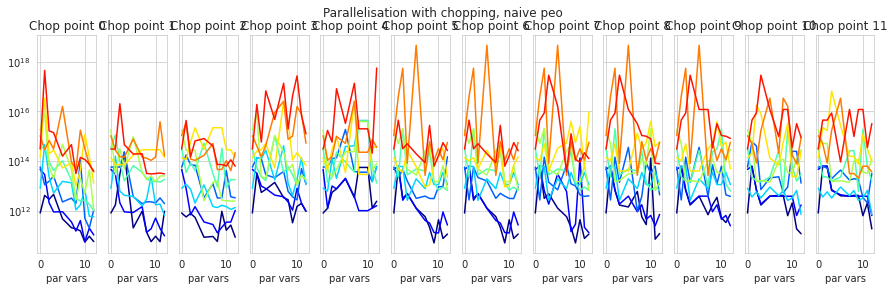

In [201]:
xs = [np.arange(chop_pts), sizes, par_vars]
#xs = [sizes, par_vars, np.arange(chop_pts)]
#names = ['Task size', 'Par vars', 'chop part']
names = ['Chop point', 'Task size', 'par vars']

trid_plot(xs, _data, names ,(1,0,2))
plt.suptitle('Parallelisation with chopping, naive peo')
plt.savefig(f'figures/chop_analysis__{experiment_name}.pdf')

In [110]:
_chopcost = np.array(costs_before_chop).reshape(len(sizes), chop_pts, 1)
trid_plot([' ', sizes, range(chop_pts)], _chopcost, ['Chop cost', 'Task size', 'Chop part'], (2,0,1))

print(_chopcost)

NameError: name 'costs_before_chop' is not defined

## Optimal chops search for task

In [196]:
optimal = _data.min(axis=1)
optimal = optimal[..., np.newaxis]
print(optimal.shape)

(9, 11, 1)


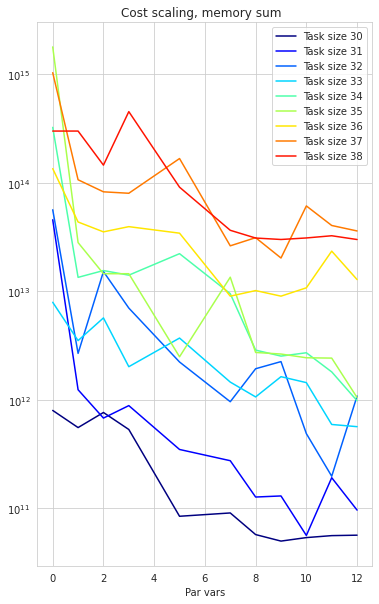

In [203]:
optimal
xs = [' ', sizes, par_vars]
trid_plot(xs, optimal, ['Cost scaling, memory sum', 'Task size', 'Par vars'], 
          (2,0,1), figsize=(6,10))
plt.savefig(f'figures/skylake_30-38_optimal_{experiment_name}_mems.pdf')
plt.legend()

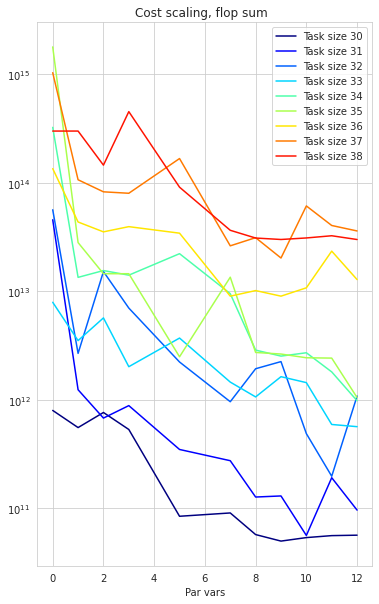

In [202]:
optimal
xs = [' ', sizes, par_vars]
trid_plot(xs, optimal, ['Cost scaling, flop sum', 'Task size', 'Par vars'],
          (2,0,1), figsize=(6,10))
plt.legend()
plt.savefig(f'figures/skylake_30-38_optimal_{experiment_name}_flops.pdf')